In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

filename = 'top_500.csv'
file = f'../data/01_raw/{filename}'

try:
    data = pd.read_csv(file)
    print(f"Plik '{file}' został poprawnie wczytany.")
except Exception as e:
    print(f"Błąd podczas wczytywania pliku: {e}")
    data = pd.DataFrame()

Plik '../data/01_raw/top_500.csv' został poprawnie wczytany.


In [2]:
# Podstawowe informacje o danych
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn\n")
display(info)

Rozmiar danych: 498 wierszy × 47 kolumn



,Typ kolumny,Brakujące wartości,Unikalne wartości
appid,int64,0,498
name,object,0,465
release_date,object,0,427
required_age,int64,0,6
price,float64,0,42
dlc_count,int64,0,51
detailed_description,object,32,433
about_the_game,object,32,433
short_description,object,29,436
reviews,object,312,167


Kolumny z wartościami numerycznymi:
['appid', 'required_age', 'price', 'dlc_count', 'metacritic_score', 'achievements', 'recommendations', 'user_score', 'score_rank', 'positive', 'negative', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'discount', 'peak_ccu', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent']


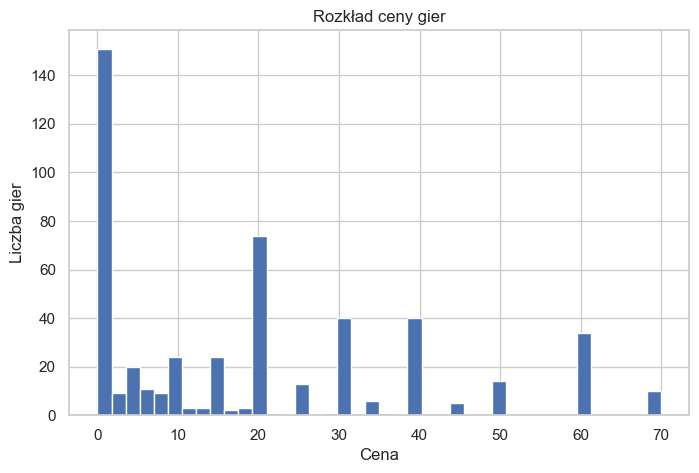

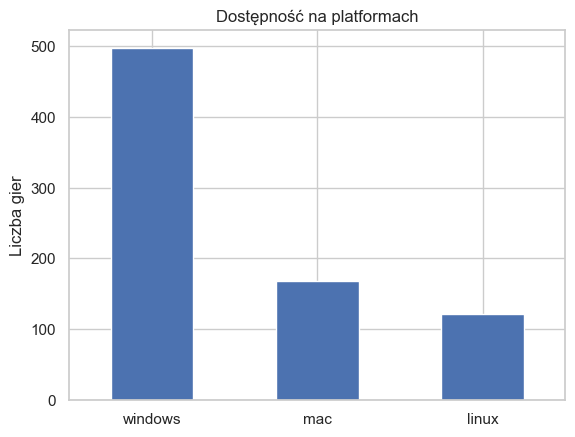

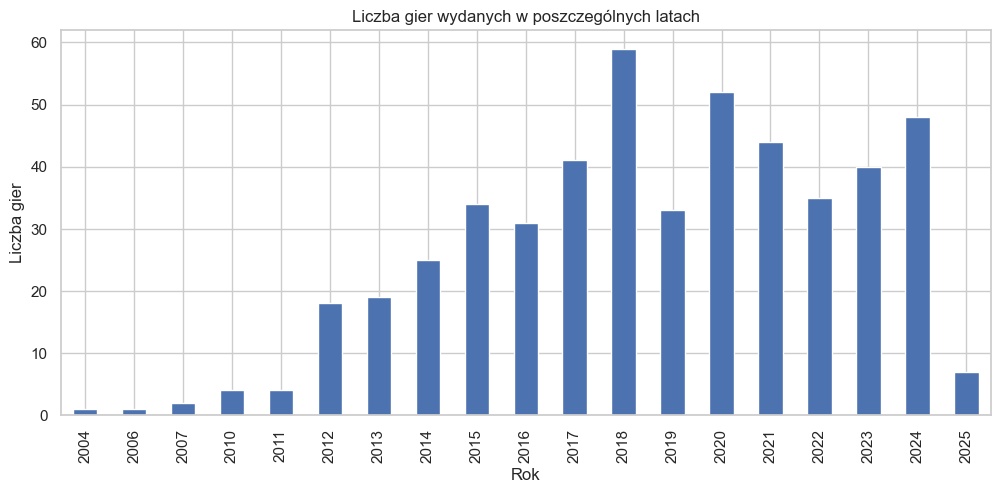

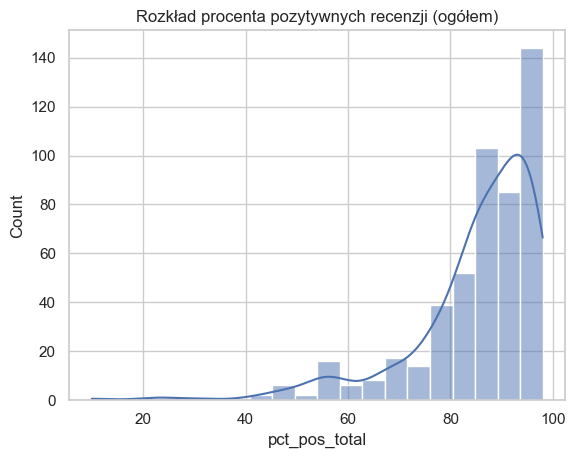

In [3]:
# Rozkład cech numerycznych

# Ustawienia wyświetlania
sns.set_theme(style="whitegrid")

# Kolumny z wartościami numerycznymi
all_num_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Kolumny z wartościami numerycznymi:")
print(list(all_num_cols))

# Histogram ceny
data["price"].plot(kind="hist", bins=40, title="Rozkład ceny gier", figsize=(8, 5))
plt.xlabel("Cena")
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier na poszczególne platformy
data[["windows", "mac", "linux"]].sum().plot(kind="bar", title="Dostępność na platformach", rot=0)
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier w poszczególnych latach
pd.to_datetime(data["release_date"], errors="coerce").dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 5))
plt.title("Liczba gier wydanych w poszczególnych latach")
plt.xlabel("Rok")
plt.ylabel("Liczba gier")
plt.show()

# Rozkład pozytywnych recenzji
sns.histplot(data['pct_pos_total'], bins=20, kde=True)
plt.title("Rozkład procenta pozytywnych recenzji (ogółem)")
plt.show()

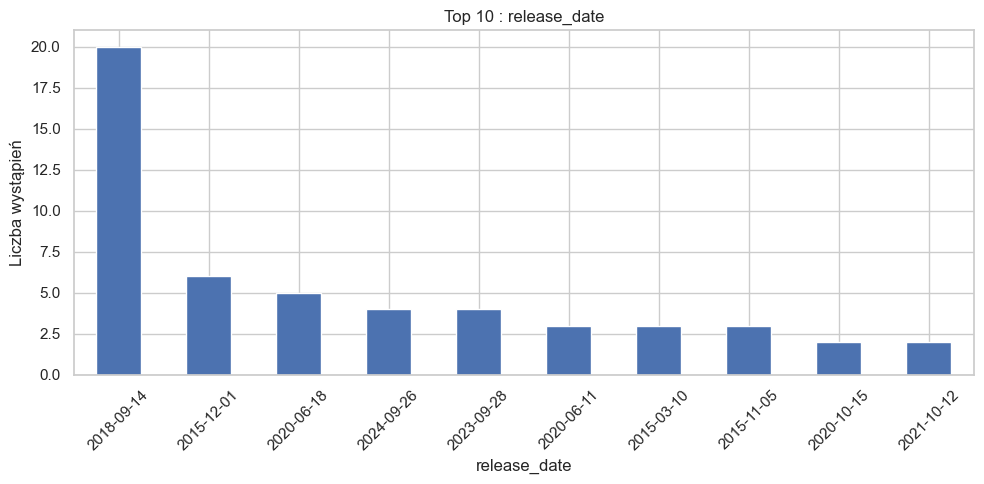

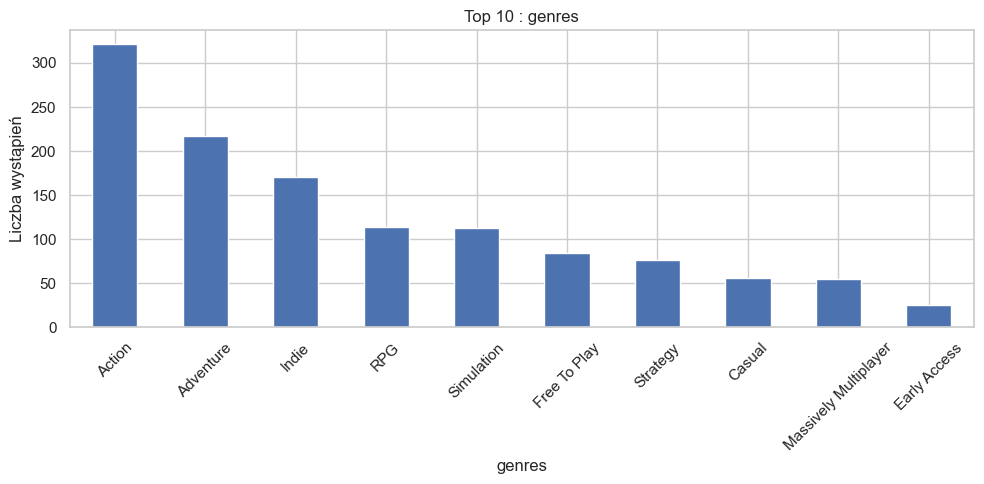

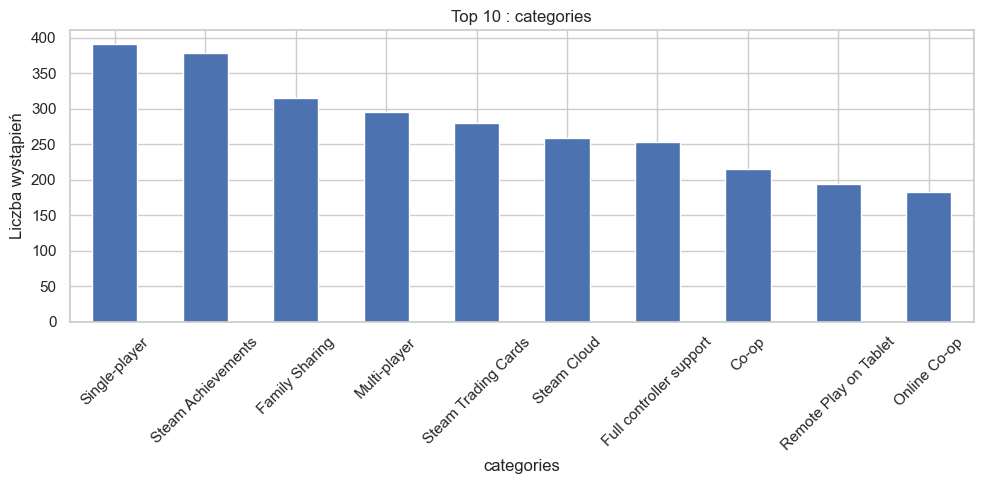

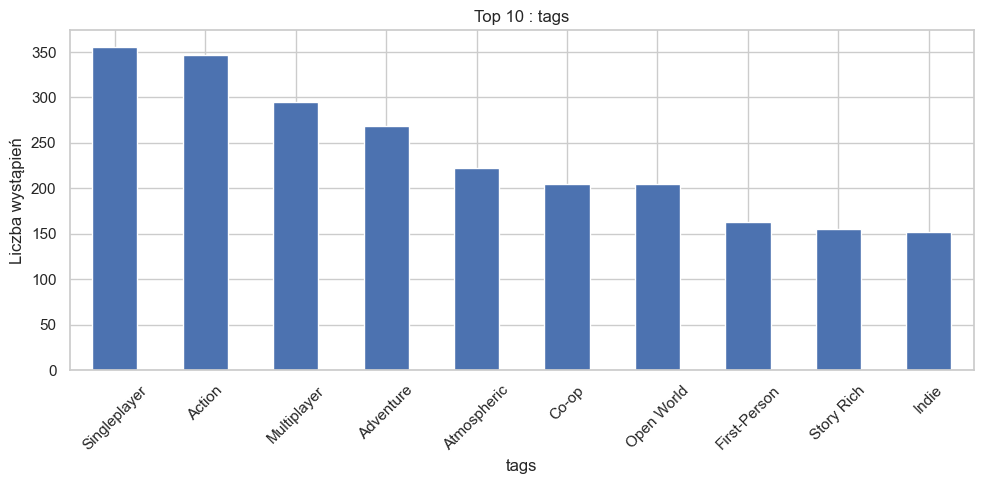

In [4]:
# Rozkład cech kategorycznych 

# Kolumny kategoryczne sensowne do analizy
cat_cols = ['release_date', 'genres', 'categories', 'tags']

for col in cat_cols:
    if col not in data.columns:
        continue  # pomijamy kolumny, których nie ma w danych

    # Kolumny typu lista do rozbicia i zliczenia
    # Niektóre kolumny mają zapis w typie string z listą, np. "['Action', 'Adventure']" przez to, że gra mieści się np. w wielu genrach
    if col in ['genres', 'categories', 'tags', 'platforms', 'steamspy_tags']:
        exploded = (data[col]
                    .dropna()
                    .apply(lambda x: eval(x) if isinstance(x, str) else x)
                    .explode())
        counts = exploded.value_counts()
    else:
        # Zwykłe kolumny w typie string
        counts = data[col].value_counts()

    # Kategorie zliczane, które warto przedstawić w zestawieniu Najczęściej występujących
    if len(counts) > 10:
        top_counts = counts[:10]
        # top_counts['Pozostałe'] = counts[10:].sum()
        plot_data = top_counts
        title = f"Top 10 : {col}"
    else:
        plot_data = counts
        title = f"Rozkład kategorii dla {col}"

    plt.figure(figsize=(10, 5))
    plot_data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Liczba wystąpień')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:


# Wstępna Agregacja danych i określenie targetu

# Usunięcie kolumn gdzie jest więcej niż 30% pustych wierszy
threshold = 0.3
for col in data.columns:
    missing_ratio = data[col].isnull().mean()
    if missing_ratio > threshold:
        print(f"[DROP] {col} (missing_ratio={missing_ratio:.2%})")
        data.drop(columns=col, inplace=True)

# Usunięcie kolumn positive i negative -> zapobieganie data leak
if {'positive', 'negative'}.issubset(data.columns):
    data.drop(columns=['positive', 'negative'], inplace=True)
    print("[DROP] columns=['positive', 'negative']")

# Enkodowanie danych kategorycznych

# Data wydania -> rok, miesiąc wydania.
if 'release_date' in data.columns:
    data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
    data['release_year'] = data['release_date'].dt.year
    data['release_month'] = data['release_date'].dt.month
    data.drop(columns=['release_date'], inplace=True)
    print("[ENCODE] release_date -> release_year, release_month")

# Dane kategoryczne na binarne -> int 0-1
bin_flag_cols = [
    'website', 'support_url', 'detailed_description', 'about_the_game', 'short_description',
    'header_image', 'screenshots', 'movies'
]
for col in bin_flag_cols:
    if col in data.columns:
        data[f"has_{col}"] = data[col].notnull().astype(int)
        data.drop(columns=[col], inplace=True)
        print(f"[ENCODE] {col} -> has_{col} (0/1)")

# Systemy operacyjne -> bool na int 0-1
platform_cols = ['windows', 'mac', 'linux']
for col in platform_cols:
    if col in data.columns:
        data[col] = data[col].fillna(False).astype(int)
        print(f"[CAST] {col}: bool -> int (0/1)")

# Usunięcie niepotrzebnych kolumn
drop_cols = [
    'num_reviews_recent',
    'pct_pos_recent',  # bardzo szybko są outdated, więc usuwamy
     'publishers',
     'developers',
     'packages'
]

for col in drop_cols:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)
        print(f"[DROP] {col}")

# TODO: zastanowić się jak to obrobić
#18  estimated_owners

# MultiLabelBinarizer dla kolumn z wieloma etykietami
#todo jezeli zostanie nam za dużo kolumn to trzeba bedzie ograniczyc do np top n etykiet ps raczej #trzeba
mlb_cols = ['genres', 'categories', 'tags','supported_languages','full_audio_languages']

for col in mlb_cols:
    if col in data.columns:
        # Zamiana tekstu typu ['A', 'B'] na listy
        data[col] = data[col].dropna().apply(lambda x: eval(x) if isinstance(x, str) else x)

        mlb = MultiLabelBinarizer()
        encoded = pd.DataFrame(mlb.fit_transform(data[col].dropna()),
                               columns=[f"{col}_{cls}" for cls in mlb.classes_],
                               index=data[col].dropna().index)

        # Dołączenie kolumn i usuniecie starej kolumny
        data = pd.concat([data, encoded], axis=1)
        data.drop(columns=[col], inplace=True)

        print(f"[ENCODE] {col} -> {len(mlb.classes_)} kolumn")

# % pozytywnych ocen -> nasz target -> 'pct_pos_total'

[DROP] reviews (missing_ratio=62.65%)
[DROP] support_email (missing_ratio=57.83%)
[DROP] metacritic_url (missing_ratio=48.59%)
[DROP] notes (missing_ratio=75.50%)
[DROP] score_rank (missing_ratio=100.00%)
[DROP] columns=['positive', 'negative']
[ENCODE] release_date -> release_year, release_month
[ENCODE] website -> has_website (0/1)
[ENCODE] support_url -> has_support_url (0/1)
[ENCODE] detailed_description -> has_detailed_description (0/1)
[ENCODE] about_the_game -> has_about_the_game (0/1)
[ENCODE] short_description -> has_short_description (0/1)
[ENCODE] header_image -> has_header_image (0/1)
[ENCODE] screenshots -> has_screenshots (0/1)
[ENCODE] movies -> has_movies (0/1)
[CAST] windows: bool -> int (0/1)
[CAST] mac: bool -> int (0/1)
[CAST] linux: bool -> int (0/1)
[DROP] num_reviews_recent
[DROP] pct_pos_recent
[DROP] publishers
[DROP] developers
[DROP] packages
[ENCODE] genres -> 12 kolumn
[ENCODE] categories -> 40 kolumn
[ENCODE] tags -> 358 kolumn
[ENCODE] supported_languages

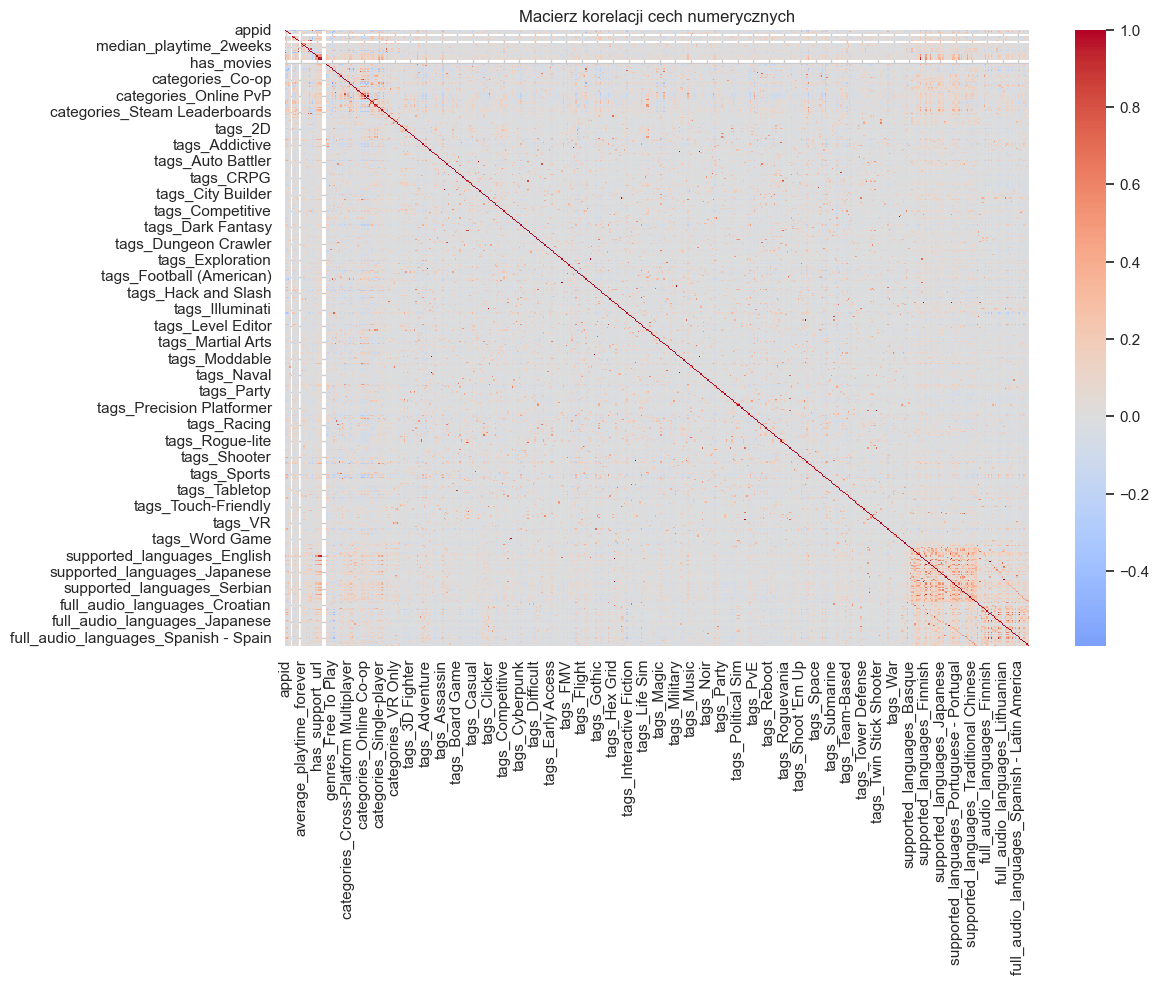

In [6]:
# Macierz korelacji
corr = data.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0,
)
plt.title("Macierz korelacji cech numerycznych")
plt.show()

In [7]:
# Podstawowe informacje o danych po operacjach
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn\n")
display(info)

Rozmiar danych: 498 wierszy × 527 kolumn



,Typ kolumny,Brakujące wartości,Unikalne wartości
appid,int64,0,498
name,object,0,465
required_age,int64,0,6
price,float64,0,42
dlc_count,int64,0,51
...,...,...,...
full_audio_languages_Thai,int64,0,2
full_audio_languages_Traditional Chinese,int64,0,2
full_audio_languages_Turkish,int64,0,2
full_audio_languages_Ukrainian,int64,0,2


In [ ]:
# Eksport danych
data.info()
print(f"\nLiczba wierszy: {data.shape[0]}")
print(f"Liczba kolumn: {data.shape[1]}")

# Zapis do pliku CSV
output_path = f"../data/02_interim/cleaned_{filename}"
data.to_csv(output_path, index=False, encoding='utf-8')

print(f"\nDane zapisane do pliku: {output_path}")